In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline
%config InlineBackend.figure_format='retina'
import glob

from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.preprocessing import StandardScaler


from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Flatten

Using TensorFlow backend.


In [2]:
# Store bowls and vases names into lists
bowls = glob.glob("Borges_assessment_data/datadir/bowl/png/*")
vases = glob.glob("Borges_assessment_data/datadir/vase/png/*")
print("There are {} bowls".format(len(bowls)),
     "\nThere are {} vases".format(len(vases)))

There are 1000 bowls 
There are 1000 vases


## Data Exploration

The image size is (256, 256, 4) 
The pixel values are in the range (0.0, 1.0)


(<matplotlib.image.AxesImage at 0x118f19c18>,
 <matplotlib.text.Text at 0x118f4ef98>)

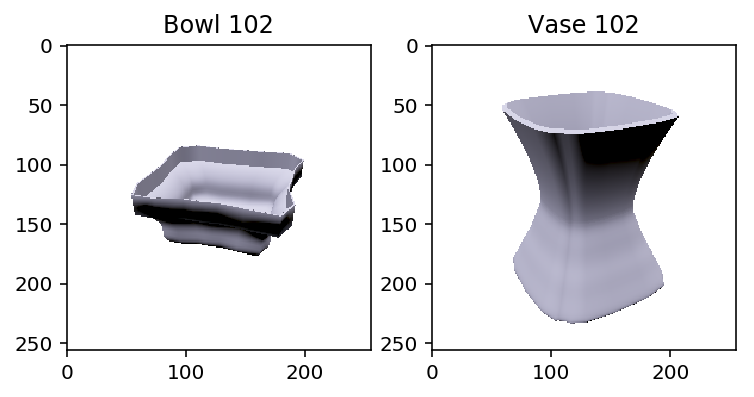

In [3]:
# Explore data
np.random.seed(42)
# randomly generate a number and select an image to show
num = np.random.randint(len(bowls))   
# Read the bowl and vase images
bowl = mpimg.imread(bowls[num])
vase = mpimg.imread(vases[num])
print("The image size is", bowl.shape,
     "\nThe pixel values are in the range", (bowl.min(), bowl.max()))

plt.subplot(121)
plt.imshow(bowl),  plt.title('Bowl {}'.format(num))
plt.subplot(122)
plt.imshow(vase),  plt.title('Vase {}'.format(num))
# plt.savefig("./output_images/bowl_vase.png")

## Data preparation
### feature engineering: use shape feature as representation
perform Sobel algorithm for edge detection, use gradient magnitude and scale to (0,1)

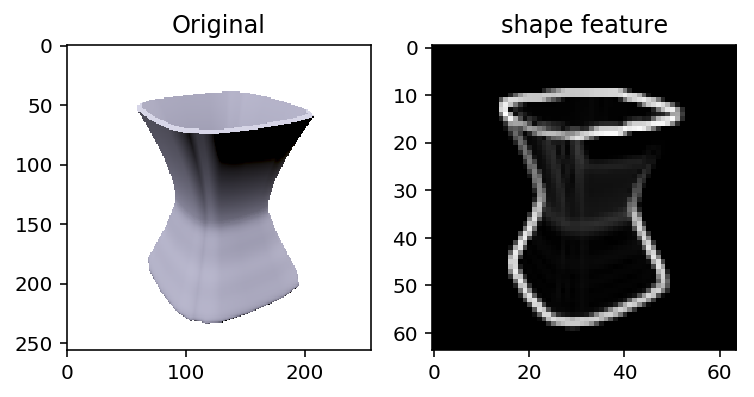

In [4]:
# Preprocessing  
def preprocess(image_name, resize = 64, training_mode = False):
    """
    Crop(conditional), resize, convert to grayscale, detect edge, and return the scaled gradient magnitude
    
    Params:
    image_name: the name of image 
    resize: resize the image
    training_mode: mode control, if True, cropping the bowl images
    
    return: scaled gradient magnitude (shape feature ranged(0,1))
    """
    img = mpimg.imread(image_name)
    # Crop the empty margins for bowl images in training 
    if training_mode and 'bowl' in image_name:
        img = img[50:-50, 30:-30]
    # Resize 
    img = cv2.resize(img, (resize,resize), interpolation=cv2.INTER_LINEAR)
    # convert to GRAY
    if img.shape[-1]==4:  # RGBA to GRAY
        gray = cv2.cvtColor(img, cv2.COLOR_RGBA2GRAY)
    elif img.shape[-1]==3: # RGB to GRAY
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Edge detection with Sobel
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=3)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=3)
    # Get the gradient magnitude
    sobel = np.sqrt(sobelx**2+sobely**2)
    return sobel/sobel.max()

# Test the function
def test_preprocess(image, save_fig=False):
    test_image = image
    resized = preprocess(test_image, resize=64, training_mode=True)
    plt.subplot(121)
    plt.imshow(mpimg.imread(test_image), cmap='gray'), plt.title('Original')
    plt.subplot(122)
    plt.imshow(resized, cmap='gray'), plt.title('shape feature')
    if save_fig is True:
        plt.savefig('./output_images/preprocessed_image.png')
test_image = vases[num]
test_preprocess(test_image, save_fig=True)

### Prepare training data
Store data in X(inputs) and y(output), and split data into training and testing datasets

In [5]:
# Prepare training data
# Store preprocessed images into an array as inputs
# Use 0 to denote a bowl and 1 to denote a vase
X = []  # store image data 
y = []  # store labels, 0:bowl, 1:vase
resize = 64
# Iterate all images for preprocessing
for image_name in bowls+vases:
    processed = preprocess(image_name, resize=resize, training_mode=True)
    X.append(processed)
# Stack the processed images in array and reshape to trainable format
X = np.stack(X).reshape(-1, resize, resize, 1)
y = np.hstack([np.zeros(len(bowls)), np.ones(len(vases))])
print("In total, there are {} data entries".format(X.shape[0]))

In total, there are 2000 data entries


In [6]:
# Data split

#Params
test_size = 0.1
random_state = 42
nb_splits = 1

# Get train, test index and split data
cv = StratifiedShuffleSplit(n_splits=nb_splits, test_size=test_size, random_state=random_state)
train, test = next(cv.split(X, y))

X_train, X_test = X[train], X[test]
y_train, y_test = y[train], y[test]
print("Training data size:", X_train.shape[0], "testing data size", X_test.shape[0],
     "\nData shape, input:", X_train[0].shape, "output:", y_train[0].shape)

Training data size: 1800 testing data size 200 
Data shape, input: (64, 64, 1) output: ()


## Build a model with keras 
### Train the model and save the mode 

In [7]:
# Build a model and train the network
epochs = 5
batch_size = 64

model = Sequential()
model.add(Conv2D(8, 5, 5, border_mode='same', activation='relu', input_shape=X.shape[1:]))
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2), border_mode='same'))
model.add(Flatten())
model.add(Dense(50,  activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(2, activation='softmax'))

model.compile(loss='sparse_categorical_crossentropy', metrics=['accuracy'], optimizer='adam')
hist = model.fit(X_train, y_train, batch_size=batch_size, nb_epoch=epochs, shuffle=True, 
          validation_split=0.1)
with(open('./model.json', 'w')) as f:
    f.write(model.to_json())
model.save_weights('./model_weights.h5')

Train on 1620 samples, validate on 180 samples
Epoch 1/5
1620/1620 [==============================] - 3s - loss: 0.0951 - acc: 0.9691 - val_loss: 8.6395e-05 - val_acc: 1.0000
Epoch 2/5
1620/1620 [==============================] - 3s - loss: 1.3917e-04 - acc: 1.0000 - val_loss: 1.2356e-05 - val_acc: 1.0000
Epoch 3/5
1620/1620 [==============================] - 3s - loss: 6.0133e-05 - acc: 1.0000 - val_loss: 8.9072e-06 - val_acc: 1.0000
Epoch 4/5
1620/1620 [==============================] - 2s - loss: 7.5476e-05 - acc: 1.0000 - val_loss: 8.3136e-06 - val_acc: 1.0000
Epoch 5/5
1620/1620 [==============================] - 3s - loss: 5.7366e-05 - acc: 1.0000 - val_loss: 5.5213e-06 - val_acc: 1.0000


## Test the model
### Test with testing data

In [8]:
# Check the accuracy for the testing dataset
loss, accu = model.evaluate(X_test,y_test)
print("\nThe accuracy for the testing dataset is", accu)

200/200 [==============================] - 0s     

The accuracy for the testing dataset is 1.0


### Test with downloaded images 

In [9]:
# Evaluate on images downloaded from google images
test_bowls = glob.glob('./test_images/bowls/*')
test_vases = glob.glob('./test_images/vases/*')
# Store images and labels into two arrays
X_eval = [preprocess(image, resize=resize) for image in test_bowls+test_vases]
X_eval = np.stack(X_eval)
X_eval = X_eval.reshape(-1,resize,resize,1)
print("Evaluating", X_eval.shape[0], "downloaded images",
     "with values between", (X_eval.min(), X_eval.max()))
y_eval = np.hstack([np.zeros(len(test_bowls)), np.ones(len(test_vases))])

Evaluating 10 downloaded images with values between (0.0, 1.0)


10/10 [==============================] - 0s
The accuracy for classifying the downloaded images is 0.80


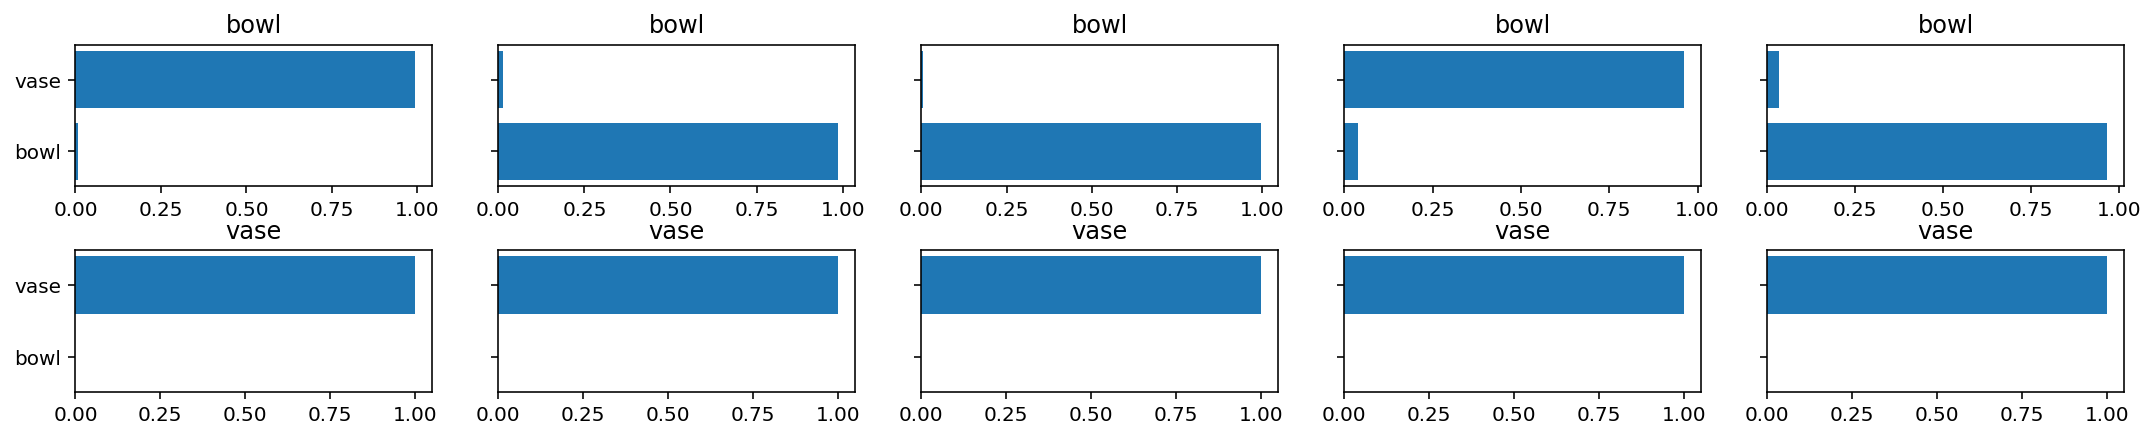

In [12]:
_, accu = model.evaluate(X_eval, y_eval)
print("The accuracy for classifying the downloaded images is {:.2f}".format(accu))

# Visualize the prediction
# Title is the image class bowl or vase
# X axis is the probability, y axis is the predicted class
preds = model.predict(X_eval)
f, axes = plt.subplots(2, 5, figsize=(15,3), sharey=True)
plt.tight_layout()
for ax, pred, name in zip(axes.flatten(), preds, ['bowl']*5+['vase']*5):
    ax.barh([0,1], pred, )
    ax.set_title(name)
    ax.set_yticks([0,1])
    ax.set_yticklabels(['bowl', 'vase'])
# f.savefig('./output_images/model_prediction.png')